In [181]:
import nltk
import spacy
from wordcloud import STOPWORDS, WordCloud
from autocorrect import Speller

import string
import unicodedata

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import re
import unicodedata
from string import punctuation


from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, auc,
                             classification_report, confusion_matrix, f1_score,
                             precision_recall_curve, recall_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, RepeatedStratifiedKFold,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 7

import warnings
warnings.filterwarnings('ignore')


In [182]:
# text preprocessing transformers
snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [183]:
# method definitions

def run_cv_SVC_Pipe(steps, params, show_classif_confusion=False, train_test=True):
    # define model
    model = SVC()
    steps.append(('m', model))
    pipeline_SM_RU = Pipeline(steps=steps)

    cv = StratifiedKFold(random_state=42, shuffle=True)

    search = GridSearchCV(pipeline_SM_RU, param_grid=params, cv=cv, scoring=['recall', 'f1', 'accuracy'], refit='recall', n_jobs=-1, return_train_score=True)
    search.fit(tfidfObject_train, y_train)
    
    useful_cv_params = [x for x in list(search.cv_results_) if not (x.startswith('split') or x.startswith('params') or x.endswith('time') or x.startswith('std') or x.startswith('rank') or x.startswith('mean_train'))]
    df_results_test = pd.DataFrame()
    for param in useful_cv_params:
        df_results_test[param] = search.cv_results_[param]
        
    useful_cv_params = [x for x in list(search.cv_results_) if not (x.startswith('split') or x.startswith('params') or x.endswith('time') or x.startswith('std') or x.startswith('rank') or x.startswith('mean_test'))]
    df_results_train = pd.DataFrame()
    for param in useful_cv_params:
        df_results_train[param] = search.cv_results_[param]
    
    if show_classif_confusion:
        if train_test:
            print('On ACTUAL y_train TRAIN DATA -> ')
            show_confusion_clssification(search.best_estimator_[len(steps)-1], tfidfObject_train, y_train)
        else:
            print('On ACTUAL y_test TEST DATA -> ')
            show_confusion_clssification(search.best_estimator_[len(steps)-1], tfidfObject_test, y_test)
        
    return (search, df_results_train, df_results_test)

def show_confusion_clssification(model, X_data,  y_data):
    y_hat = model.predict(X_data)
    print('F1 SCORE: ', f1_score(y_data, y_hat))
    print('RECALL SCORE: ', recall_score(y_data, y_hat))
    
    print(classification_report(y_data, y_hat))
    ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_data, y_hat)).plot()


contractions_dict = {     
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "iit will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

def lemmatize( text):
    """
    take string input and lemmatize the words.
    use WordNetLemmatizer to lemmatize the words.
    """
    word_tokens = nltk.word_tokenize(text)
    lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in word_tokens]
    return (" ".join(lemmatized_word))

def remove_numbers(text):
    """
    take string input and return a clean text without numbers. 
    Use regex to discard the numbers.
    """
    output = ''.join(c for c in text if not c.isdigit())
    return output

def remove_punct(text):
    """
    take string input and clean string without punctuations.
    use regex to remove the punctuations.
    """
    return ''.join(c for c in text if c not in punctuation)

def remove_stopwords(sentence, stop_words):
    """
    removes all the stop words like "is,the,a, etc."
    5 lines of code can be written in one line as:
        return ' '.join([w for w in word_tokenize(sentence) if not w in stop_words]) 
    """
    clean_sent =[]
    for w in word_tokenize(sentence):
        if not w in stop_words:
            clean_sent.append(w)
    return " ".join(clean_sent)

def remove_Tags(text):
    """
    take string input and clean string without tags.
    use regex to remove the html tags.
    """
    cleaned_text = re.sub('<[^<]+?>','', text)
    return cleaned_text

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_URL(text):
    return re.sub(r'http\S+', '', text)
    #sample_text = 'this is link for https://lms.simplilearn.com/courses/3817/PG-DS---Natural-Language-Processing/assessment simplilearn....another link https://www.google.com/'
    #remove_URL(sample_text)

def sentence_tokenize(text):
    """
    take string input and return list of sentences.
    use nltk.sent_tokenize() to split the sentences.
    """
    sent_list=[]
    for w in nltk.sent_tokenize(text):
        sent_list.append(w)
    return sent_list

def autospell(text):
    """
    correct the spelling of the word.
    """
    spells = [Speller().autocorrect_word(w) for w in (nltk.word_tokenize(text))]
    return " ".join(spells)

def stemming(text):
    """
    take string input and stem the words.
    use snowball_stemmer to stem the string.
    """
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    return " ".join(stemmed_word)

def to_lower(text):
    """
    Converting text to lower case as in, converting "Hello" to "hello" or "HELLO" to "hello".
    """
    return ' '.join([w.lower() for w in word_tokenize(text)])

def word_tokenize(text, length=None):
    """
    take string input and return list of words.
    use nltk.word_tokenize() to split the words.
    """
    word_list=[]
    for sentences in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentences):
            if length is not None:
                if len(word) <= length:
                    word_list.append(word)
            else:
                word_list.append(word)
    return word_list

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
    #remove_accented_chars('Sómě Áccěntěd těxt')

def remove_linebreaks(text):
    return text.replace('\n', ' ').replace('\r', ' ')

def remove_IP(text):
    # declaring the regex pattern for IP addresses
    # text_after = re.sub(regex_search_term, regex_replacement, text_before)
    return re.sub(r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})', '', text)
    #sample_ip = '123.268.2.1 test1 256.122.12.122'
    #remove_IP(sample_ip)


def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                    flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def stem_lemma(text):
    """
    take string input and stem the words.
    use snowball_stemmer to stem the string.
    """
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [snowball_stemmer.stem(wordnet_lemmatizer.lemmatize(word)) for word in word_tokens]
    return " ".join(stemmed_word)    

def preprocess_Wiki(text, stop_words):
    text = remove_IP(text)
    text = remove_URL(text)
    
    # text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # text = re.sub(r'@', '', text)
    # text = re.sub(r'#', '', text)
    # text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    # text = re.sub("'s", "", text)
    
    text = remove_linebreaks(text)
    #text = remove_accented_chars(text)
    text = remove_stopwords(text, stop_words=stop_words)
    text = expand_contractions(text, contractions_dict)
    text = remove_stopwords(text, stop_words=stop_words)
    text = remove_punct(text)
    text = to_lower(text)
    
    text = remove_numbers(text)
    # text = lemmatize(text)
    # text = stemming(text)
    text = stem_lemma(text)
    
    # do not take words whose length are greater than 20
    text = word_tokenize(text)
    
    return ' '.join(text)

def preprocesscustom_stpwords(text, stop_words):
    text = remove_stopwords(text, stop_words=stop_words)
    text = word_tokenize(text)
    return ' '.join(text)


***
### Remove from stopwords words like no , not.. which may be prerequiite to toxicity
***

In [184]:
str(stop_words)

'{"doesn\'t", \'into\', \'who\', \'mightn\', \'doing\', "aren\'t", "that\'ll", \'from\', \'will\', \'my\', \'very\', \'he\', \'over\', \'having\', \'re\', \'him\', \'i\', \'between\', \'wouldn\', \'of\', \'for\', "don\'t", \'above\', \'against\', \'his\', \'a\', "hadn\'t", "it\'s", \'won\', "mustn\'t", \'herself\', \'wasn\', \'below\', \'yourself\', \'same\', \'too\', \'how\', \'o\', \'shan\', \'if\', \'shouldn\', "wouldn\'t", \'am\', "shouldn\'t", "she\'s", \'m\', "hasn\'t", \'theirs\', \'whom\', "needn\'t", \'d\', \'in\', \'further\', \'only\', \'then\', "couldn\'t", \'those\', \'all\', "you\'ve", \'until\', \'out\', \'these\', \'aren\', \'itself\', \'being\', \'isn\', \'this\', \'where\', \'has\', \'don\', \'have\', "mightn\'t", \'did\', \'both\', \'haven\', \'s\', \'themselves\', \'before\', \'than\', \'but\', \'nor\', "didn\'t", \'through\', "weren\'t", \'when\', \'here\', \'more\', \'it\', \'and\', \'each\', \'so\', \'should\', \'about\', \'there\', \'me\', \'with\', \'their\', \

In [185]:
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('don')
stop_words.remove('won')
stop_words.remove('nor')
stop_words.remove('were')
stop_words.remove('haven')

In [186]:
wiki = pd.read_csv('content/train.csv')
wiki

,id,comment_text,toxic
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0
...,...,...,...
4995,60229df7b48ba6ff,"""\r\n\r\n Dildo, if you read my response corre...",0
4996,36a645227572ec5c,"CALM DOWN, CALM DOWN, DON'T GET A BIG DICK",1
4997,6d47fa39945ed6f5,In my opinion Dougweller is using his privileg...,0
4998,de2e4c0d38db6e30,The style section has been expanded too. I did...,0


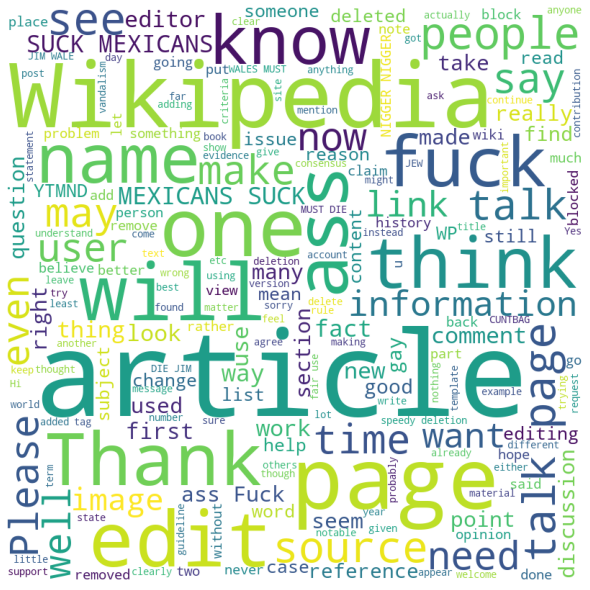

In [187]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(' '.join(wiki['comment_text']))

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [188]:
wiki.isna().sum()

id              0
comment_text    0
toxic           0
dtype: int64

***
### no Nan's detected
***

In [189]:
wiki.toxic.value_counts()

0    4563
1     437
Name: toxic, dtype: int64

***
### Data lable is highly imbalanced...we will use SMOTE later after preprocessing data
### Preprocessing text
>### Using regular expressions, remove IP addresses
>### Using regular expressions, remove URLs
>### Normalize the casing
>### Tokenize using word_tokenize from NLTK
>### Remove stop words
>### Remove punctuation
***

In [190]:
# add more items to stop words...common words to remove
for x in range(ord('b'), ord('z')+1):
    stop_words.add(chr(x))

wiki['preprocess_wiki'] = wiki['comment_text'].apply(preprocess_Wiki, args=(stop_words,))
wiki['length'] = wiki['preprocess_wiki'].apply(len)
wiki['deciles'] = pd.qcut(wiki.length, np.arange(0, 1.1, 0.1), labels=np.arange(0,10,1).astype(str))
wiki

,id,comment_text,toxic,preprocess_wiki,length,deciles
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,a barnstar the defend wiki barnstar i like edi...,210,6
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,this seem unbalanc whatev i said mathsci said ...,529,9
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,marya dzmitruk born minsk belarus march her mo...,1138,9
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,talkback dear celestia,22,0
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0,new categori i honest think need add categori ...,240,7
...,...,...,...,...,...,...
4995,60229df7b48ba6ff,"""\r\n\r\n Dildo, if you read my response corre...",0,dildo read respons correct i never said i go a...,304,7
4996,36a645227572ec5c,"CALM DOWN, CALM DOWN, DON'T GET A BIG DICK",1,calm down calm down do nt get a big dick,40,1
4997,6d47fa39945ed6f5,In my opinion Dougweller is using his privileg...,0,in opinion dougwel use privileg poor person at...,101,4
4998,de2e4c0d38db6e30,The style section has been expanded too. I did...,0,the style section expand i nt rememb i place tag,48,2


***
### Additional labelling of data based on text length(deciles in increasing order)...later this is also used o stratify dataset into train and test along with toxic label
***

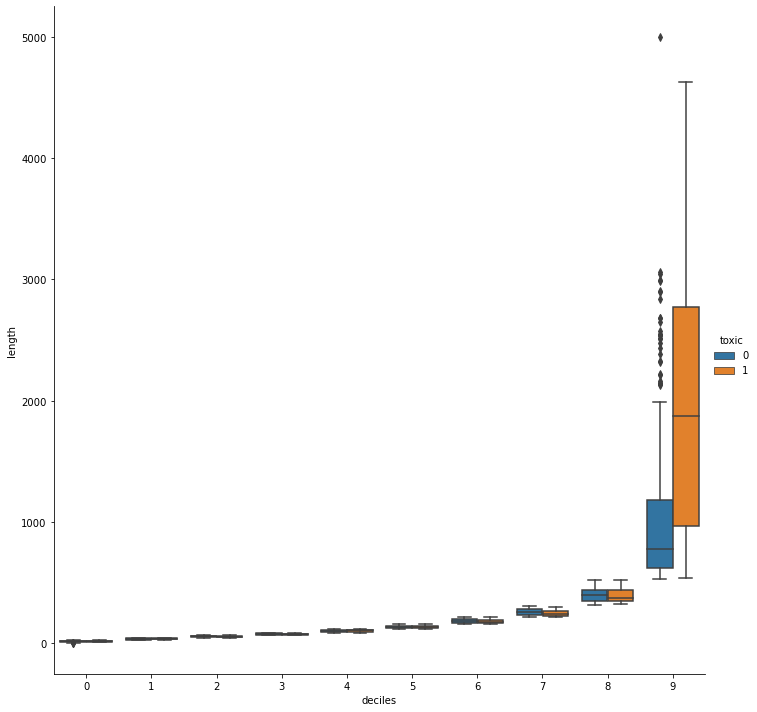

In [191]:
sns.catplot(data=wiki, x='deciles', y='length', kind='box', hue='toxic', height=10)

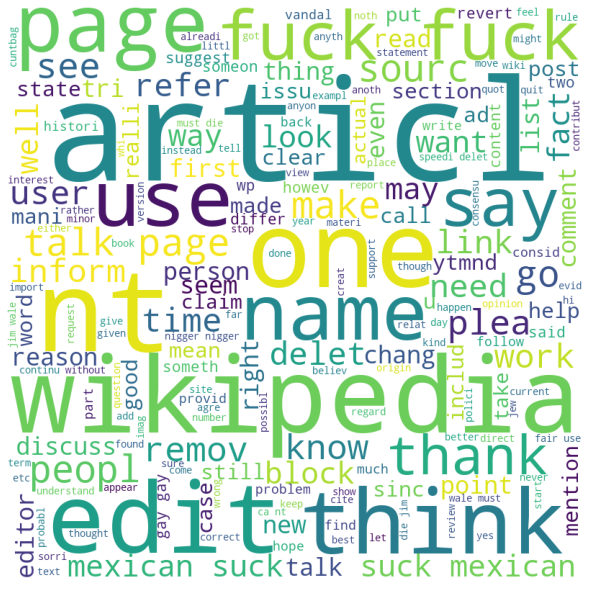

In [192]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(' '.join(wiki['preprocess_wiki']))

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

***
### Using a counter, find the top terms in the data. 
### Can any of these be considered contextual stop words? 
### Words like “Wikipedia”, “page”, “edit” are examples of contextual stop words
### If yes, drop these from the data
***

In [193]:
cv = CountVectorizer()
vec = cv.fit(wiki['preprocess_wiki'])
bow = cv.transform(wiki['preprocess_wiki'])
sum_of_words = bow.sum(axis=0)
words_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [194]:
custom_stopwords = []
nlp = spacy.load('en_core_web_lg')

In [195]:
def get_nlp_results(text):
    doc = nlp(text)
    entity = doc.ents[0].label_ if len(doc.ents) > 0 else np.NaN
    #return (token[0].pos_, entity)
    for token in doc:
        return pd.Series([entity, token.lemma_, token.pos_, token.tag_, token.dep_,
                token.shape_, token.is_alpha, token.is_stop])

In [196]:
df_most_freq_words = pd.DataFrame(words_freq, columns=['word', 'freq'])
df1 = pd.DataFrame(df_most_freq_words['word'].apply(get_nlp_results))
df1.columns = ['entity', 'token.lemma_', 'token.pos_', 'token.tag_', 'token.dep_',
                'token.shape_', 'token.is_alpha', 'token.is_stop']
df2 = pd.concat([df_most_freq_words, df1], axis=1)
df2

,word,freq,entity,token.lemma_,token.pos_,token.tag_,token.dep_,token.shape_,token.is_alpha,token.is_stop
0,not,3035,NaN,not,PART,RB,ROOT,xxx,True,True
1,articl,2219,NaN,articl,PROPN,NNP,ROOT,xxxx,True,False
2,page,1853,NaN,page,NOUN,NN,ROOT,xxxx,True,False
3,nt,1798,NaN,not,PART,RB,ROOT,xx,True,False
4,the,1579,NaN,the,PRON,DT,ROOT,xxx,True,True
...,...,...,...,...,...,...,...,...,...,...
16903,opinio,1,NaN,opinio,X,LS,ROOT,xxxx,True,False
16904,priveleg,1,NaN,priveleg,NOUN,NN,ROOT,xxxx,True,False
16905,repulican,1,NORP,repulican,ADJ,JJ,ROOT,xxxx,True,False
16906,hazelton,1,GPE,hazelton,PROPN,NNP,ROOT,xxxx,True,False


***
### Remove Cardinal values(one., two, million, thousand...)
***

In [197]:
spacy.explain('CARDINAL')

'Numerals that do not fall under another type'

In [198]:
df2[df2['entity'] == 'CARDINAL'].head(20)

,word,freq,entity,token.lemma_,token.pos_,token.tag_,token.dep_,token.shape_,token.is_alpha,token.is_stop
14,one,919,CARDINAL,one,NUM,CD,ROOT,xxx,True,True
118,two,242,CARDINAL,two,NUM,CD,ROOT,xxx,True,True
387,three,93,CARDINAL,three,NUM,CD,ROOT,xxxx,True,True
453,four,77,CARDINAL,four,NUM,CD,ROOT,xxxx,True,True
582,five,59,CARDINAL,five,NUM,CD,ROOT,xxxx,True,True
1028,half,30,CARDINAL,half,NOUN,NN,ROOT,xxxx,True,False
1179,zero,25,CARDINAL,zero,NUM,CD,ROOT,xxxx,True,False
1294,six,22,CARDINAL,six,NUM,CD,ROOT,xxx,True,True
1705,seven,15,CARDINAL,seven,NUM,CD,ROOT,xxxx,True,False
1718,ten,15,CARDINAL,ten,NUM,CD,ROOT,xxx,True,True


In [199]:
custom_stopwords.extend(df2[df2['entity'] == 'CARDINAL']['word'].to_list())
# df2 = df2.drop(df2[df2['entity'] == 'CARDINAL'].index.values)
# df2[df2['entity'] == 'CARDINAL'].head(20) # confirm deletioin

***
### Remove Organizatioins which are proper nouns
***

In [200]:
spacy.explain('ORG')

'Companies, agencies, institutions, etc.'

In [201]:
df2[(df2['entity'] == 'ORG') & (df2['token.pos_'] == 'PROPN')]

,word,freq,entity,token.lemma_,token.pos_,token.tag_,token.dep_,token.shape_,token.is_alpha,token.is_stop
5,wikipedia,1440,ORG,wikipedia,PROPN,NNP,ROOT,xxxx,True,False
41,imag,494,ORG,imag,PROPN,NNP,ROOT,xxxx,True,False
89,polici,282,ORG,polici,PROPN,NNP,ROOT,xxxx,True,False
105,issu,257,ORG,issu,PROPN,NNP,ROOT,xxxx,True,False
127,notabl,231,ORG,notabl,PROPN,NNP,ROOT,xxxx,True,False
...,...,...,...,...,...,...,...,...,...,...
16883,zltan,1,ORG,zltan,PROPN,NNP,ROOT,xxxx,True,False
16884,ibrahimov,1,ORG,ibrahimov,PROPN,NNP,ROOT,xxxx,True,False
16891,lvds,1,ORG,lvds,PROPN,NNP,ROOT,xxxx,True,False
16895,admimistr,1,ORG,admimistr,PROPN,NNP,ROOT,xxxx,True,False


In [202]:
custom_stopwords.extend(df2[(df2['entity'] == 'ORG') & (df2['token.pos_'] == 'PROPN')]['word'].values)
# df2 = df2.drop(df2[(df2['entity'] == 'ORG') & (df2['token.pos_'] == 'PROPN')].index.values)
# df2[(df2['entity'] == 'ORG') & (df2['token.pos_'] == 'PROPN')] # confirm deletioin

***
### Remove Nouns
***

In [203]:
spacy.explain('NNP')

'noun, proper singular'

In [204]:
custom_stopwords.extend(df2[df2['token.tag_'] == 'NNP']['word'].values)

***
### Remove duplicates in custom stop words
***

In [205]:
# remove duplicates
custom_stopwords = list(set(custom_stopwords))

***
### Remove custom stop words from preprocessed column
***

In [206]:
wiki['preprocess_wiki_custom'] = wiki['preprocess_wiki'].apply(preprocesscustom_stpwords, args=(custom_stopwords,))
wiki


,id,comment_text,toxic,preprocess_wiki,length,deciles,preprocess_wiki_custom
0,e617e2489abe9bca,"""\r\n\r\n A barnstar for you! \r\n\r\n The De...",0,a barnstar the defend wiki barnstar i like edi...,210,6,a barnstar the defend barnstar i like edit pag...
1,9250cf637294e09d,"""\r\n\r\nThis seems unbalanced. whatever I ha...",0,this seem unbalanc whatev i said mathsci said ...,529,9,this seem unbalanc whatev i said mathsci said ...
2,ce1aa4592d5240ca,"Marya Dzmitruk was born in Minsk, Belarus in M...",0,marya dzmitruk born minsk belarus march her mo...,1138,9,dzmitruk born her mother nikolaevna moroz born...
3,48105766ff7f075b,"""\r\n\r\nTalkback\r\n\r\n Dear Celestia... """,0,talkback dear celestia,22,0,dear celestia
4,0543d4f82e5470b6,New Categories \r\n\r\nI honestly think that w...,0,new categori i honest think need add categori ...,240,7,new categori i honest think need add categori ...
...,...,...,...,...,...,...,...
4995,60229df7b48ba6ff,"""\r\n\r\n Dildo, if you read my response corre...",0,dildo read respons correct i never said i go a...,304,7,dildo read correct i never said i go vandal i ...
4996,36a645227572ec5c,"CALM DOWN, CALM DOWN, DON'T GET A BIG DICK",1,calm down calm down do nt get a big dick,40,1,calm down calm down do nt get a big
4997,6d47fa39945ed6f5,In my opinion Dougweller is using his privileg...,0,in opinion dougwel use privileg poor person at...,101,4,in opinion dougwel use privileg poor person at...
4998,de2e4c0d38db6e30,The style section has been expanded too. I did...,0,the style section expand i nt rememb i place tag,48,2,the style section expand i nt i place tag


***
### ML
***

***
Separate into train and test sets

Use train-test method to divide your data into 2 sets: train and test

Use a 70-30 split

Use TF-IDF values for the terms as feature to get into a vector space model

Import TF-IDF vectorizer from sklearn

Instantiate with a maximum of 4000 terms in your vocabulary


### Certain comments are very long while some very short....Distribute evenly these lengths amongst train and test
>### In that, take all toxic comments and train test split (70:30) stratified on length of text(deciles in increasing order)
>### Repeat for non-toxic 
### Combine then toxic and non-toxic together to get stratified (toxic/non-toxic) and with evely distributed lengths of comments

>### We train test split 70:30 based on text length from both toxic and non-toxic comments...This way we make sure we have a balanced density in dimention of train and test set are balanced

>Combine then these train and test sets with respecive labels (0,1) thus still having stratified data
***

In [207]:
df_toxic = wiki[wiki.toxic==1]
df_nontoxic = wiki[wiki.toxic==0]

In [208]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(df_nontoxic['preprocess_wiki_custom'].values, 
                                                                    df_nontoxic.deciles.astype(int), 
                                                                    test_size=0.3, 
                                                                    stratify=df_nontoxic.deciles.astype(int))
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(df_toxic['preprocess_wiki_custom'].values, 
                                                                    df_toxic.deciles.astype(int), 
                                                                    test_size=0.3, 
                                                                    stratify=df_toxic.deciles.astype(int))

In [209]:
print(X_train_pos.shape, X_test_pos.shape)
print(X_train_neg.shape, X_test_neg.shape)

(3194,) (1369,)
(305,) (132,)


In [210]:
X_train = np.concatenate([X_train_pos, X_train_neg])
X_test = np.concatenate([X_test_pos, X_test_neg])
y_train = np.concatenate([np.repeat(0, X_train_pos.shape[0]), np.repeat(1, X_train_neg.shape[0])])
y_test = np.concatenate([np.repeat(0, X_test_pos.shape[0]), np.repeat(1, X_test_neg.shape[0])])

***
### Confirm we have label stratified data on train and test
***

<AxesSubplot:ylabel='count'>

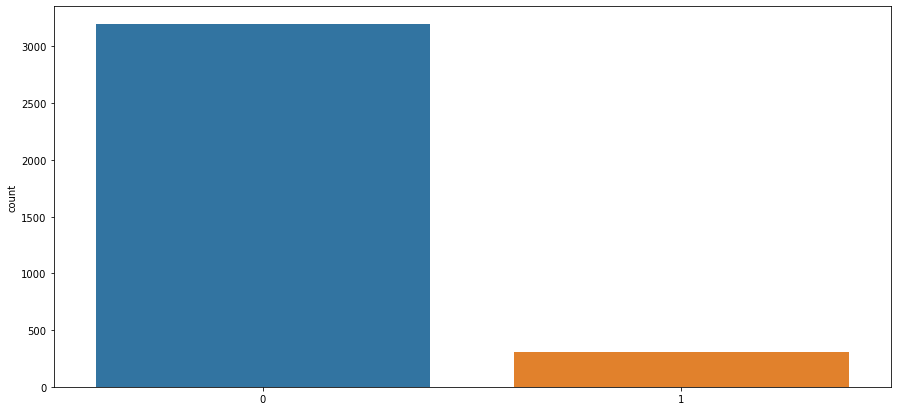

In [211]:
sns.countplot(y_train)

<AxesSubplot:ylabel='count'>

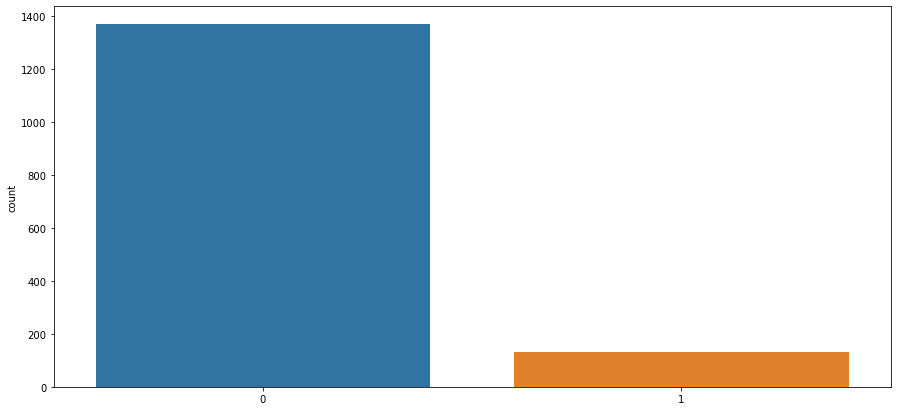

In [212]:
sns.countplot(y_test)

In [213]:
# tfidf on entire corpus to capture all vocabulary ...so combine X_test and X_train comments
X_all = np.concatenate([X_train, X_test])
tfidfvect = TfidfVectorizer(max_features = 4000, ngram_range=(1,2))
tfidfvect = tfidfvect.fit(X_all)


In [214]:
# transform seperately train and test
tfidfObject_train = tfidfvect.transform(X_train)
tfidfObject_test = tfidfvect.transform(X_test)

***
### Model building: Support Vector Machine
>### Instantiate SVC from sklearn with a linear kernel
>### Fit on the train data
>### Make predictions for the train and the test set
***

Train Scores: 

F1 SCORE:  0.8403041825095058
RECALL SCORE:  0.7245901639344262
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3194
           1       1.00      0.72      0.84       305

    accuracy                           0.98      3499
   macro avg       0.99      0.86      0.91      3499
weighted avg       0.98      0.98      0.97      3499



Test Scores: 

F1 SCORE:  0.3803680981595092
RECALL SCORE:  0.23484848484848486
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1369
           1       1.00      0.23      0.38       132

    accuracy                           0.93      1501
   macro avg       0.97      0.62      0.67      1501
weighted avg       0.94      0.93      0.91      1501



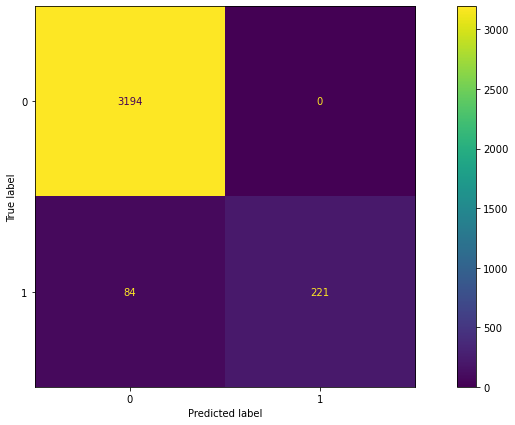

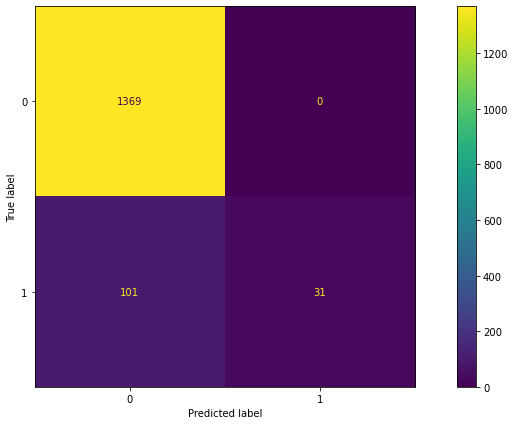

In [215]:
rfclf = SVC(random_state=42)
rfclf.fit(tfidfObject_train, y_train)

print('Train Scores: \n')
show_confusion_clssification(rfclf, tfidfObject_train, y_train)

print('\n\nTest Scores: \n')
show_confusion_clssification(rfclf, tfidfObject_test, y_test)

***
The data is highly imbalanced and is completely biased with majority of non-toxic.

Report the accuracy on the train set
>We have accuracy of 98%. However due to huge imbalance in data, this score is largely contributed by TN(majority of non-toxic) and hence we cannot take accuracy as metric.
>Such model traind based on acuracy score can perform poorly on a majority toxic biased data.

Report the recall(True Positive Rate/ sensitivity) on the train set:decent, high, low?
>100% (no FP) on non-toxic meaning model is able to completely capture non-toxic without any misclassification. It is fairly evident model is complete biased towards non-toxic.

>model misclassified 72% (84 samples) as non-toxic(FN)

>>The Cost Sensitivity of misclassification is too high, in that, 84 samples of toxic cases were classified as non-toxic (False Negative)

>Model completely biased towards non-toxic

>Since we are interested in rarer event's(toxicity on wiki), we focus on improving on this aspect

Get the f1_score on the train set
>99% on non-toxic so we have a good balance between precision and recall

>84% on toxic...we track this in our next steps where we improve on recall which tend to reduce precision in turn reducing F1-score
  
Objective:
> Focus on aggressive toxic model (TP for toxic max) compormising on FP (non-toxic as toxic classified)

> Further develpment on ensemble techniques to redce FP non-toxic and toxic

***

***
### Choosing SMOTE with Tomek links as it has highest score on recall
### Hyperparameter tuning
***

On ACTUAL y_test TEST DATA -> 
F1 SCORE:  0.427061310782241
RECALL SCORE:  0.7651515151515151
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1369
           1       0.30      0.77      0.43       132

    accuracy                           0.82      1501
   macro avg       0.63      0.79      0.66      1501
weighted avg       0.91      0.82      0.85      1501

BEST PARAMS:  {'m__C': 5000, 'm__class_weight': {0: 0.8, 1: 0.2}, 'm__kernel': 'linear', 'm__random_state': 42}
BEST (refit) Recall Score:  0.7573770491803279


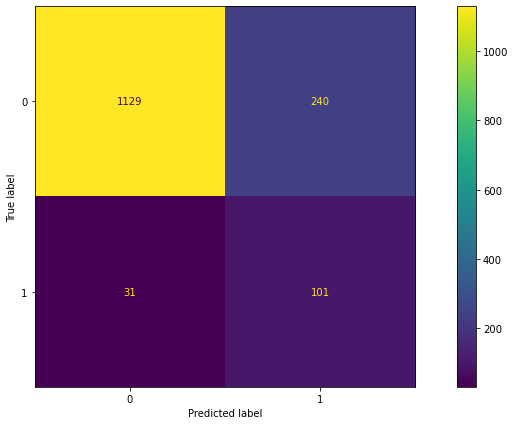

In [229]:
# define sampling
over_under = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
steps = [('ou', over_under)]
params = {'m__kernel': ['linear'], 
          'm__C' :[1,5, 7, 8, 9, 10, 50, 100, 5000],
          'm__random_state' : [42],
          'm__class_weight' : [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.7, 1: 0.3}, {0: 0.6, 1: 0.4}, {0: 0.5, 1: 0.5}, 'balanced']}

cv, df_results_train, df_results_test = run_cv_SVC_Pipe(steps, params, show_classif_confusion=True,  train_test=False)
print('BEST PARAMS: ', cv.best_params_)
print('BEST (refit) Recall Score: ', cv.best_score_)

On ACTUAL y_test TEST DATA -> 
F1 SCORE:  0.4324324324324324
RECALL SCORE:  0.7878787878787878
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1369
           1       0.30      0.79      0.43       132

    accuracy                           0.82      1501
   macro avg       0.64      0.80      0.66      1501
weighted avg       0.92      0.82      0.85      1501

BEST PARAMS:  {'m__C': 8000, 'm__class_weight': {0: 0.9, 1: 0.1}, 'm__kernel': 'linear', 'm__random_state': 42}
BEST (refit) Recall Score:  0.7540983606557378


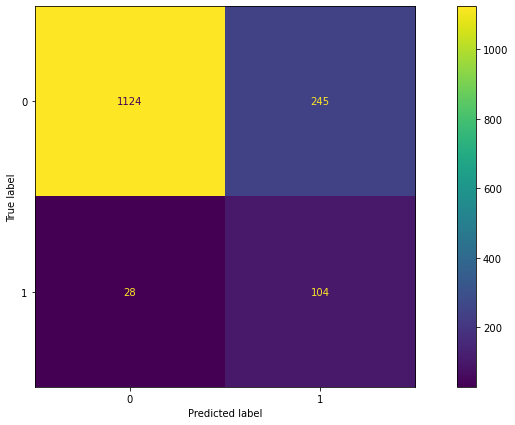

In [230]:
# define sampling
over_under = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
steps = [('ou', over_under)]
params = {'m__kernel': ['linear'], 
          'm__C' :[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
          'm__random_state' : [42],
          'm__class_weight' : [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.7, 1: 0.3}, {0: 0.6, 1: 0.4}, {0: 0.5, 1: 0.5}, 'balanced']}

cv, df_results_train, df_results_test = run_cv_SVC_Pipe(steps, params, show_classif_confusion=True,  train_test=False)
print('BEST PARAMS: ', cv.best_params_)
print('BEST (refit) Recall Score: ', cv.best_score_)

On ACTUAL y_test TEST DATA -> 
F1 SCORE:  0.4212678936605317
RECALL SCORE:  0.7803030303030303
              precision    recall  f1-score   support

           0       0.97      0.81      0.89      1369
           1       0.29      0.78      0.42       132

    accuracy                           0.81      1501
   macro avg       0.63      0.80      0.65      1501
weighted avg       0.91      0.81      0.85      1501

BEST PARAMS:  {'m__C': 4400, 'm__class_weight': {0: 0.9, 1: 0.1}, 'm__kernel': 'linear', 'm__random_state': 42}
BEST (refit) Recall Score:  0.7573770491803279


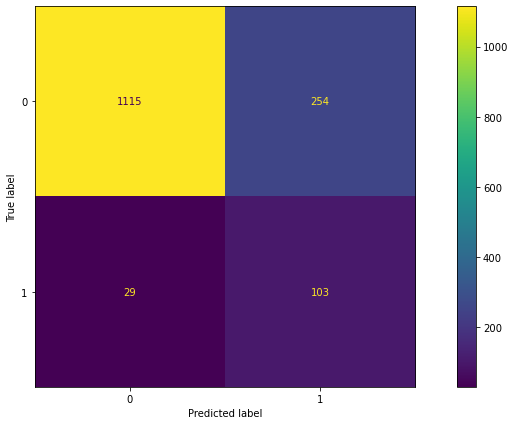

In [228]:
# define sampling
over_under = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
steps = [('ou', over_under)]
params = {'m__kernel': ['linear'], 
          'm__C' :np.arange(3000, 6000, 200),
          'm__random_state' : [42],
          'm__class_weight' : [{0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.7, 1: 0.3}, {0: 0.6, 1: 0.4}, {0: 0.5, 1: 0.5}, 'balanced']}

cv, df_results_train, df_results_test = run_cv_SVC_Pipe(steps, params, show_classif_confusion=True,  train_test=False)
print('BEST PARAMS: ', cv.best_params_)
print('BEST (refit) Recall Score: ', cv.best_score_)

***
>### Choosing above model as final with params {'m__C': 4000, 'm__class_weight': {0: 0.9, 1: 0.1}, 'm__kernel': 'linear', 'm__random_state': 42}
***

***
# Result on TFIDF + SMOTE + SVC on train
>### Predict using best estimator
***

F1 SCORE:  0.9721641190667739
RECALL SCORE:  0.945835942391985
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3194
           1       1.00      0.95      0.97      3194

    accuracy                           0.97      6388
   macro avg       0.97      0.97      0.97      6388
weighted avg       0.97      0.97      0.97      6388



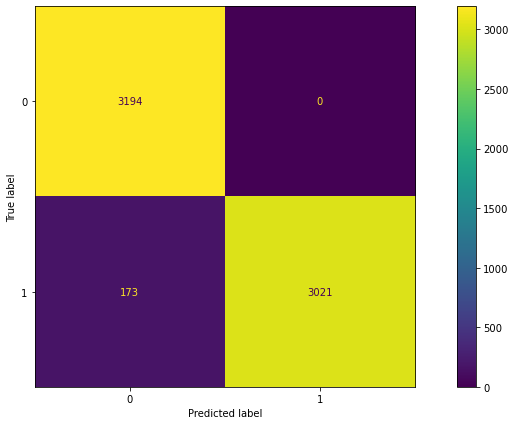

In [236]:
over_under = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_resampled, y_resampled = over_under.fit_resample(tfidfObject_train, y_train)
show_confusion_clssification(cv.best_estimator_.named_steps['m'], X_resampled, y_resampled)

***
# Result on just TFIDF Test data
***

F1 SCORE:  0.4324324324324324
RECALL SCORE:  0.7878787878787878
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1369
           1       0.30      0.79      0.43       132

    accuracy                           0.82      1501
   macro avg       0.64      0.80      0.66      1501
weighted avg       0.92      0.82      0.85      1501



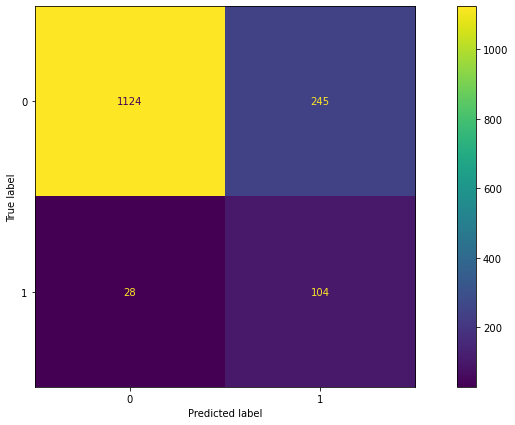

In [237]:
show_confusion_clssification(cv.best_estimator_.named_steps['m'], tfidfObject_test, y_test)

***
### Best Params : {'m__C': 4000, 'm__class_weight': {0: 0.9, 1: 0.1}, 'm__kernel': 'linear', 'm__random_state': 42}
### Considering macro average, we have 80% recall (a descent balance on toxic and non-toxic) whereas F1-score is around 66% (which is not so good and unbalanced for toxic and non-toxic)
### Subject for further text preprocessing and ensemble learning
***

***
What are the most prominent terms in the toxic comments?

Separate the comments from the test set that the model identified as toxic

Make one large list of the terms

Get the top 15 terms
***

In [222]:
df_test = pd.DataFrame({'Test Comments': X_test, 'Actual': y_test, 'Predicted': y_hat_test})
df_test = df_test[df_test.Predicted == 1]
df_test

,Test Comments,Actual,Predicted
0,this page written like prove point not like pr...,0,1
3,i adventur billion player site,0,1
5,i rude insult everi turn includ,0,1
6,giant not sure entri giant remov clever vandal...,0,1
12,gee geez whizz whizz thank i give present,0,1
...,...,...,...
1495,suck donkey ball yeah,1,1
1496,go ahead defend status quo held mainstream med...,1,1
1498,lse life h n last chanc d d d thank repeat qut...,1,1
1499,sure make sens you ca nt support reason fall b...,1,1


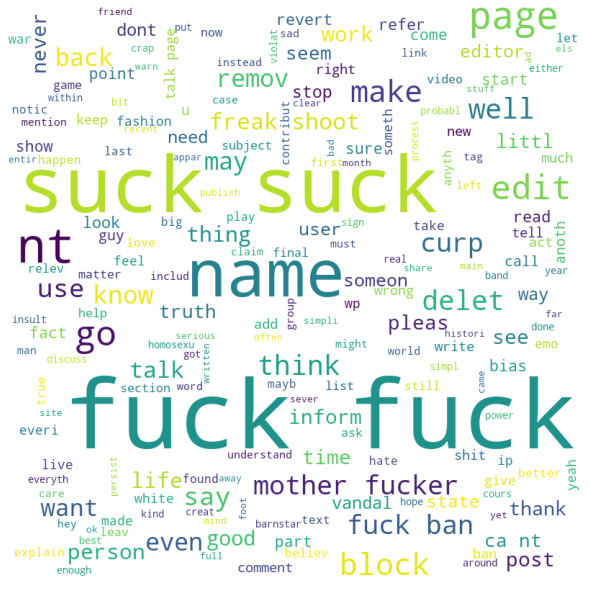

In [223]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(' '.join(df_test['Test Comments']))

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [224]:
cv = CountVectorizer()
vec = cv.fit(df_test['Test Comments'])
bow = cv.transform(df_test['Test Comments'])
sum_of_words = bow.sum(axis=0)
words_freq = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print('Top 15 tgerms from test:')
words_freq[0:15]

Top 15 tgerms from test:


[('fuck', 629),
 ('suck', 369),
 ('the', 316),
 ('in', 250),
 ('of', 250),
 ('name', 246),
 ('not', 172),
 ('you', 166),
 ('nt', 143),
 ('page', 79),
 ('like', 77),
 ('go', 59),
 ('edit', 55),
 ('get', 54),
 ('do', 54)]